# Advanced ML, Recomendation project : 

### Description of the General topic:  
 
A recommendation system is a class of machine learning tools designed to suggest 
relevant items to users based on their preferences, behaviors, and other users’ 
activities. They are widely used across e-commerce, streaming platforms, social 
media, and online advertising, aiming to enhance user experience by delivering 
personalized content or product suggestions.

### Flow of the Code Project (All in Python)  :  
 
**Data Preprocessing:** 
- Preprocess the database by filtering users and items on number of ratings. 
 
**Building Collaborative Filtering Models:** 
- Introduction user similarity based recommendation
- Implement SVD for matrix factorization. 
- NeuMF
- MLP

## **Introduction to user similarity based recommendation** : 

In [1]:
import pandas as pd
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO

/Users/aminerazig/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_recommendation = pd.read_csv("data/base de donnée_20_20.csv")

meta_file = "data/meta_Musical_Instruments.jsonl"
with open(meta_file, 'r') as file:
    metadata = [json.loads(line) for line in file]

df_metadata = pd.DataFrame([
    {
        "id": item["parent_asin"],
        "main_category": item["main_category"],
        "title": item["title"],
        "average_rating": item["average_rating"],
        "rating_number": item["rating_number"],
        "features": item["features"],
        "description": item["description"],
        "price": item["price"],
        "images": item["images"],
        "videos": item["videos"],
        "store": item["store"],
        "categories": item["categories"],
        "details": item["details"],
        "bought_together": item["bought_together"],
    }
    for item in metadata
])

df_recommendation.head(5)

,user,id,rating
0,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000EEHKVY,5.0
1,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000TGSM6E,5.0
2,AE23JYHGEN3D35CHE5OQQYJOW5RA,B008FDSWJ0,5.0
3,AE23JYHGEN3D35CHE5OQQYJOW5RA,B012VQ5A7S,5.0
4,AE23JYHGEN3D35CHE5OQQYJOW5RA,B076ZSHQ47,3.0


#### Import of products metadata : 


# Data Fields

## For User Reviews

| Field              | Type   | Explanation                                                                                                                                                     |
|--------------------|--------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `rating`           | float  | Rating of the product (from 1.0 to 5.0).                                                                                                                        |
| `title`            | str    | Title of the user review.                                                                                                                                       |
| `text`             | str    | Text body of the user review.                                                                                                                                   |
| `images`           | list   | Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by `small_image_url`, `medium_image_url`, and `large_image_url`. |
| `asin`             | str    | ID of the product.                                                                                                                                              |
| `parent_asin`      | str    | Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually the parent ID. Please use parent ID to find product meta. |
| `user_id`          | str    | ID of the reviewer.                                                                                                                                             |
| `timestamp`        | int    | Time of the review (unix time).                                                                                                                                 |
| `verified_purchase`| bool   | User purchase verification.                                                                                                                                     |
| `helpful_vote`     | int    | Helpful votes of the review.                                                                                                                                    |


# I- Collaborative Filtering

Collaborative filtering recommends products to users based on the behavior of other users with similar preferences. CF methods work on the principle that users who agreed on items in the past are likely to agree again. 
It is an alternative to content filtering that relies only on past user behavior—for example, previous transactions or product ratings— without requiring the creation of explicit profiles.Collaborative filtering analyzes relationships between users and interdependencies among products to identify new user-item associations.

One of the approaches is : 
### a) User-Based Collaborative Filtering
This approach identifies users who have similar preferences and recommends items that similar users liked.

### Implementation
We can try to implement this method using matrix factorization techniques like **Singular Value Decomposition (SVD)**, which reduces the dimensionality of the data matrix, capturing latent factors that explain user-item interactions.


In [3]:
print(f"The number of unique products is : {df_recommendation.id.nunique()}")
print(f"The number of unique users is : {df_recommendation.user.nunique()}")

The number of unique products is : 1003
The number of unique users is : 5107


In [4]:
df_recommendation.groupby('id')['rating'].count().sort_values(ascending = False)

id
B09857JRP2    473
B0BCK6L7S5    434
B0BPJ4Q6FJ    421
B0BSGM6CQ9    404
B0BTC9YJ2W    299
             ... 
B07FYL7LW1     20
B016B6YFDO     20
B002H3EZMC     20
B00M9BSZMI     20
B07H87XJ19     20
Name: rating, Length: 1003, dtype: int64

In the context of Collaborative Filtering, users can use cosine similarity to measure how similar their preferences are to other users preferences. Chances are you might like the same products in the selection.

In [5]:
df_recommendation_pivot = df_recommendation.pivot(index='user', columns='id', values='rating')

In [6]:
df_recommendation_pivot = df_recommendation_pivot.fillna(0)

In [7]:
df_recommendation_pivot

id,1423414357,B00005ML71,B0002CZVWS,B0002D01K4,B0002D01KO,B0002D0CCQ,B0002D0CEO,B0002D0CNA,B0002D0L5E,B0002D0Q2W,...,B0C6J149WZ,B0C6J1BN77,B0C6J1X7TD,B0C6J2DPBW,B0C994NVQK,B0C9NGP88D,B0CB98SMQR,B0CBHMCGNS,B0CBK1WSMR,B0CCK4YYNM
user,,,,,,,,,,,,,,,,,,,,,
AE23JYHGEN3D35CHE5OQQYJOW5RA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23WLBRYKEC67DM43M6E2MF7GPQ,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23ZFVUOMPKR57BVSWXV34QLMVA,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE24I2EU3AJAAKBXF367XSV37U6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHZPLXCE5YQMLXFFBSURYHZUGMTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHZQPH7HHSWLUIQFWEQ54NNKKN6A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHZT6MVWNF4GG6FISMZMORKZKK4A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Cosine Similarity** : 
Web page for the formula and the explaindantion about this metric :  https://en.wikipedia.org/wiki/Cosine_similarity


$$
\text{cosine similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}
$$

Where:
- \( A \) and \( B \) are vectors.
- \( A • B \) is the dot product of \( A \) and \( B \).
- \( \|A\| \) and \( \|B\| \) are the  norms of \( A \) and \( B \).


In [8]:
def Cosine_similarity (a,b) : 
    """cosine similarity between two vectors"""

    vec1 = np.array(a)
    vec2 = np.array(b)
    
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0  # NO division by zero
    else:
        return dot_product / (norm_vec1 * norm_vec2)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
# The similarity matrix is a square matrix wich gives the similaritie values between two users based on the formula (scalar product)
similarity_matrix = cosine_similarity(df_recommendation_pivot)

In [10]:
df_similarity_matrix = pd.DataFrame(similarity_matrix, index= df_recommendation_pivot.index, columns= df_recommendation_pivot.index)
df_similarity_matrix

user,AE23JYHGEN3D35CHE5OQQYJOW5RA,AE23LDQTB7L76AP6E6WPBFVYL5DA,AE23WLBRYKEC67DM43M6E2MF7GPQ,AE23ZFVUOMPKR57BVSWXV34QLMVA,AE24I2EU3AJAAKBXF367XSV37U6Q,AE24ZJSXZFHFKZF3UYR5CBAYGL7A,AE25GU3LWQGZJN4NNT5GWAGBN2KA,AE27PVJOEVGOHYF5WOXQDZ5NIULA,AE2AVSTY2ZSZUSXZA7GWMXC56ITQ,AE2BCWBDERZKN3ACIXQQISI3LHPA,...,AHZJVJET7N5JKBRKL6E7SMZV6FKQ,AHZKUBNYPXGNNNH5GQKSHJH5A7IA,AHZLJECK27R55RFTZXFUEZIVGHGQ,AHZNF3H5YLL623I5C6PO3TVZFXSQ,AHZNULZBLXPYXTCJSZ6FHCFM2Y5A,AHZPLXCE5YQMLXFFBSURYHZUGMTA,AHZQPH7HHSWLUIQFWEQ54NNKKN6A,AHZT6MVWNF4GG6FISMZMORKZKK4A,AHZXMBKQJTVG2J7P7EB5WCYTOLDQ,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ
user,,,,,,,,,,,,,,,,,,,,,
AE23JYHGEN3D35CHE5OQQYJOW5RA,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.20109,0.0,0.147115,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AE23LDQTB7L76AP6E6WPBFVYL5DA,0.0,1.000000,0.000000,0.039735,0.0,0.000000,0.109632,0.0,0.000000,0.0,...,0.221340,0.00000,0.0,0.000000,0.071853,0.0,0.000000,0.000000,0.109938,0.161294
AE23WLBRYKEC67DM43M6E2MF7GPQ,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.058036,0.000000,0.033162,0.000000
AE23ZFVUOMPKR57BVSWXV34QLMVA,0.0,0.039735,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.070186,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.097176,0.000000,0.000000,0.053323
AE24I2EU3AJAAKBXF367XSV37U6Q,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.212814,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHZPLXCE5YQMLXFFBSURYHZUGMTA,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
AHZQPH7HHSWLUIQFWEQ54NNKKN6A,0.0,0.000000,0.058036,0.097176,0.0,0.089002,0.000000,0.0,0.000000,0.0,...,0.065613,0.00000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.081474,0.000000
AHZT6MVWNF4GG6FISMZMORKZKK4A,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.185231,0.00000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.184006,0.000000


#### **Selection of a user :** 

In [11]:
# Get similar users :
select_userid = "AE23LDQTB7L76AP6E6WPBFVYL5DA"

# Weight matrix which takes the weighted average of similarities between a user and other users. 
# The weight matrix is used to give more importance to users who provide more frequent ratings 
# than others when calculating the average similarity : 

similarities = df_similarity_matrix[select_userid].drop(select_userid) # Nous donne le vecteur des similarité de notre utilsateur avec les autres
weights = similarities/similarities.sum() # calcul des poids 

In [12]:
similarities

user
AE23JYHGEN3D35CHE5OQQYJOW5RA    0.000000
AE23WLBRYKEC67DM43M6E2MF7GPQ    0.000000
AE23ZFVUOMPKR57BVSWXV34QLMVA    0.039735
AE24I2EU3AJAAKBXF367XSV37U6Q    0.000000
AE24ZJSXZFHFKZF3UYR5CBAYGL7A    0.000000
                                  ...   
AHZPLXCE5YQMLXFFBSURYHZUGMTA    0.000000
AHZQPH7HHSWLUIQFWEQ54NNKKN6A    0.000000
AHZT6MVWNF4GG6FISMZMORKZKK4A    0.000000
AHZXMBKQJTVG2J7P7EB5WCYTOLDQ    0.109938
AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ    0.161294
Name: AE23LDQTB7L76AP6E6WPBFVYL5DA, Length: 5106, dtype: float64

In [13]:

def plot_images( item_id, df_metadata):
    """
    Plot an item for a given item id.
    """
    nom_item = df_metadata[df_metadata['id'] == item_id]["title"].iloc[0]
    image_url = df_metadata[df_metadata['id'] == item_id]['images'].iloc[0][0]['large']
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Create a plot
    fig, axs = plt.subplots(1, 1, figsize=(2, 2))  # Smaller figure size
    axs.imshow(img)
    axs.set_title(f"Item {item_id}\n Name : {nom_item}", fontsize=10)
    axs.axis('off')
    plt.tight_layout()
    plt.show()


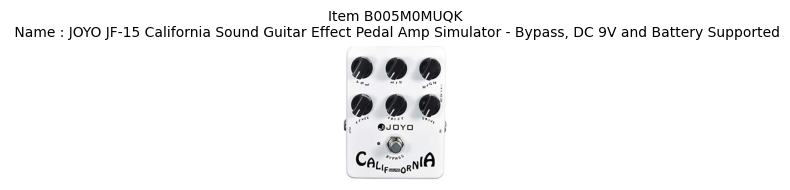

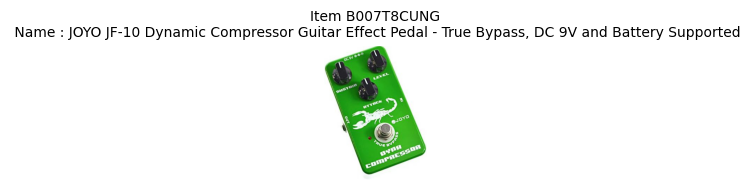

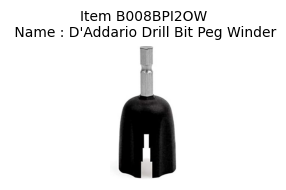

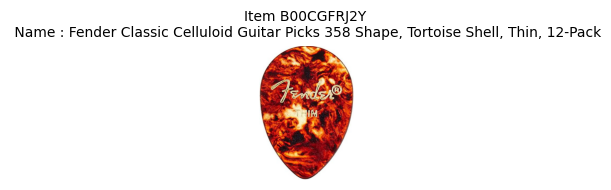

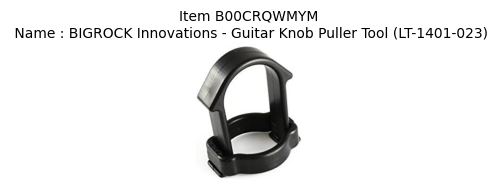

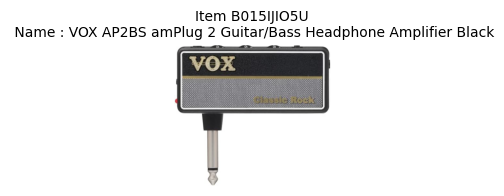

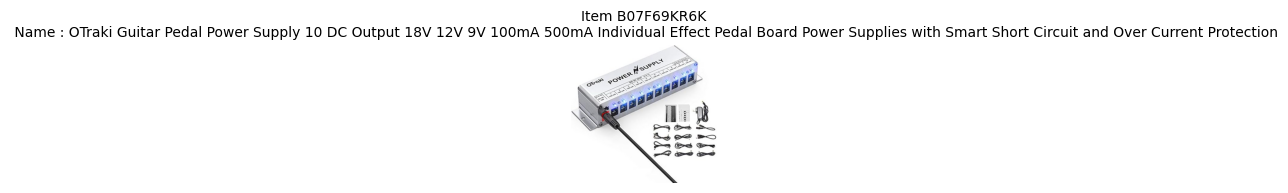

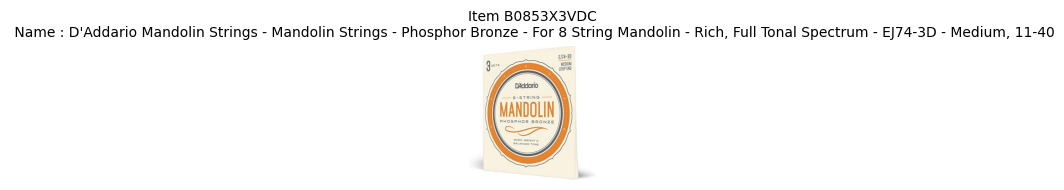

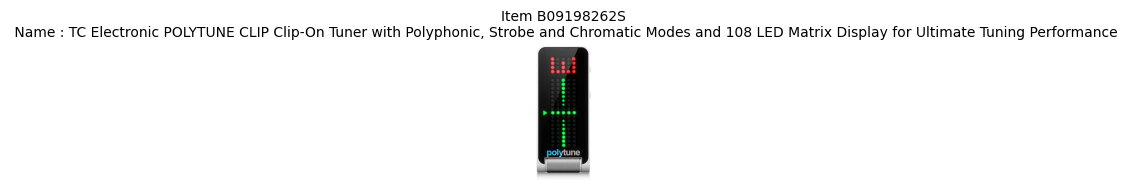

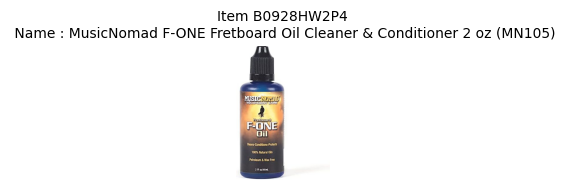

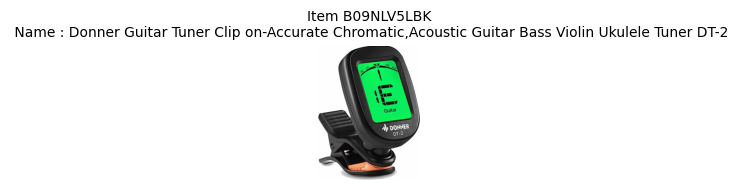

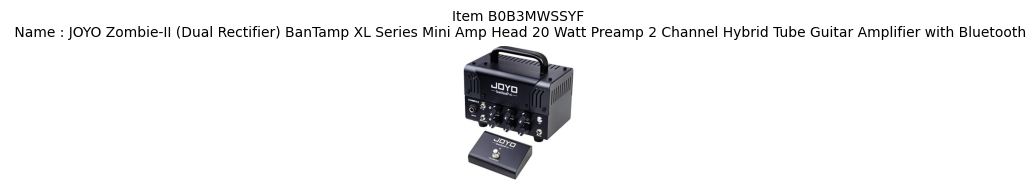

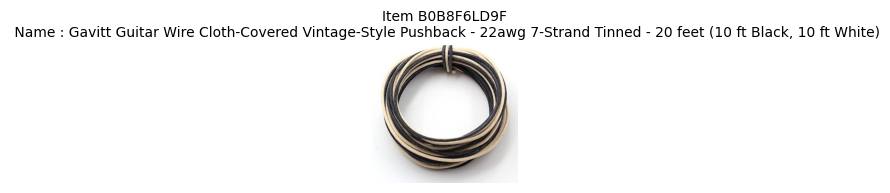

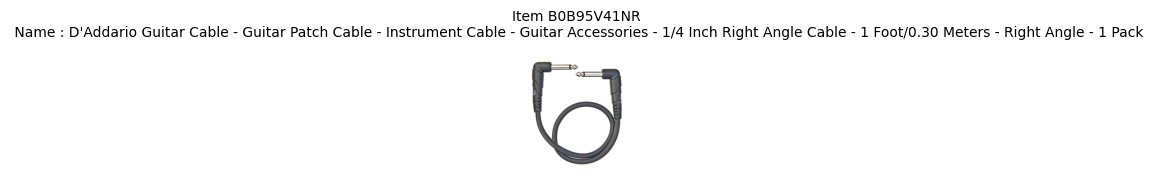

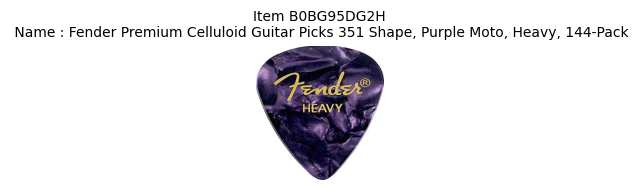

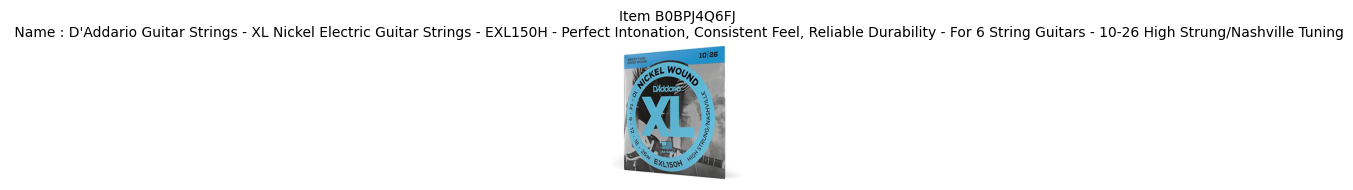

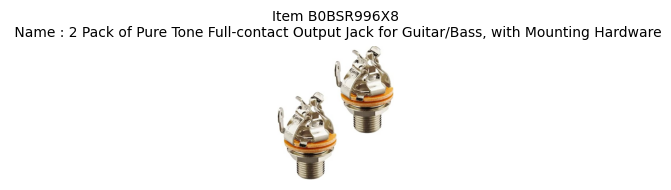

In [14]:
# products that this user have bought : 
products_rated_by_a = df_recommendation_pivot.loc[select_userid, df_recommendation_pivot.loc[select_userid, :] != 0].index
for id in products_rated_by_a : 
    plot_images(id, df_metadata)

#### **Similar Users  :** 

we calculate the similarity between a **target user** and other users in the system to find similar users. The process involves creating a **weight matrix** that accounts for the similarity between the target user and other users, normalizing the similarities to give more weight to users with higher similarity.

1. **Target User Selection:**
   To begin, we first choose a **target user** (let’s denote this user as \( u_t \)) for whom we want to find similar users. For this example, we choose `user id = AE3335XF4PMHSXKTW5B7N7EALG3Q` as the target user:
   
   $$ u_t = AE3335XF4PMHSXKTW5B7N7EALG3Q $$

2. **Similarity Calculation:**
   We calculate the **similarity** between the target user \( u_t \) and all other users using a **similarity matrix** \( S \), where each entry \( S_{ij} \) represents the similarity between user \( i \) and user \( j \). 

   The **similarity vector** for the target user \( u_t \) is represented as:
   
   $$ \text{similarities}_{u_t} = S_{u_t} $$
   
   we also  remove the similarity between the target user and themselves:
   
   $$ \text{similarities}_{u_t, \text{others}} = S_{u_t} \setminus \{ S_{u_t, u_t} \} $$

1. **Weight Calculation:**
   After obtaining the similarity scores between the target user \( u_t \) and other users, we create a **weight matrix** where each user's similarity score is normalized. This ensures that users who are more similar to the target user are given higher weight. The weight for each user \( i \) is calculated by normalizing the similarity score:

   $$ w_i = \frac{S_{u_t, i}}{\sum_{j \neq u_t} S_{u_t, j}} $$

   Where:
   - \( w_i \) is the weight for user \( i \),
   - \( S_{u_t, i} \) is the similarity between the target user \( u_t \) and user \( i \),
   - The denominator is the sum of the similarities between the target user \( u_t \) and all other users (excluding \( u_t \)).



#### **Similar users :** 

In [15]:
#num of silimar users
k = 10

#set a threshold for similarity : only users with a similarity score greater than 0.5 will be considered
user_similarity_threshold =  0.3

# top k similar users
similar_users = df_similarity_matrix[df_similarity_matrix[select_userid]>user_similarity_threshold][select_userid].sort_values(ascending=False)[:k]
similar_users_df = similar_users.to_frame(name='similarity')

print (f"The similar (with similarity bigger than {user_similarity_threshold} of cosine similarity) users to user {select_userid} are  : ")

for index, row in similar_users_df.iterrows():
    similarity = row['similarity'] 
    print(f"User: {index}, Similarity: {similarity}")

The similar (with similarity bigger than 0.3 of cosine similarity) users to user AE23LDQTB7L76AP6E6WPBFVYL5DA are  : 
User: AE23LDQTB7L76AP6E6WPBFVYL5DA, Similarity: 1.0
User: AGKLMAODCW3RR4EBYZHPG7VV7J6A, Similarity: 0.3138762255948909
User: AGWSL6RCSUEPR5RGTVMO5HERQUEA, Similarity: 0.3082056047334018


In [16]:
similar_users_df

,similarity
user,
AE23LDQTB7L76AP6E6WPBFVYL5DA,1.000000
AGKLMAODCW3RR4EBYZHPG7VV7J6A,0.313876
AGWSL6RCSUEPR5RGTVMO5HERQUEA,0.308206


#### **Bought and not bought products :** 

In [17]:
# The products the selected user boughts and rateed more than 3/5 :
bought_products = df_recommendation_pivot.loc[df_recommendation_pivot.index== select_userid, df_recommendation_pivot.loc[select_userid,:]>=3]
bought_products

id,B005M0MUQK,B007T8CUNG,B008BPI2OW,B00CGFRJ2Y,B00CRQWMYM,B015IJIO5U,B07F69KR6K,B0853X3VDC,B09198262S,B0928HW2P4,B09NLV5LBK,B0B3MWSSYF,B0B8F6LD9F,B0B95V41NR,B0BG95DG2H,B0BPJ4Q6FJ,B0BSR996X8
user,,,,,,,,,,,,,,,,,
AE23LDQTB7L76AP6E6WPBFVYL5DA,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [18]:
#list of non rated product by our user
#not_rated_by_user = df_recommendation_pivot[df_recommendation_pivot.loc[select_userid, :] == 0]
not_rated_by_user = df_recommendation_pivot[(df_recommendation_pivot.loc[select_userid, :] == 0).index[(df_recommendation_pivot.loc[select_userid, :] == 0).values]]

In [19]:
not_bought_products = df_recommendation_pivot.loc[
    df_recommendation_pivot.index != select_userid,  # Exclude selected user
    not_rated_by_user.columns  # products not rated by the selected user
]


In [20]:
# a sub-matrix of the recommendation pivot table containing only products that select_userid has not rated.
not_bought_products

id,1423414357,B00005ML71,B0002CZVWS,B0002D01K4,B0002D01KO,B0002D0CCQ,B0002D0CEO,B0002D0CNA,B0002D0L5E,B0002D0Q2W,...,B0C6J149WZ,B0C6J1BN77,B0C6J1X7TD,B0C6J2DPBW,B0C994NVQK,B0C9NGP88D,B0CB98SMQR,B0CBHMCGNS,B0CBK1WSMR,B0CCK4YYNM
user,,,,,,,,,,,,,,,,,,,,,
AE23JYHGEN3D35CHE5OQQYJOW5RA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23WLBRYKEC67DM43M6E2MF7GPQ,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23ZFVUOMPKR57BVSWXV34QLMVA,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE24I2EU3AJAAKBXF367XSV37U6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
AE24ZJSXZFHFKZF3UYR5CBAYGL7A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHZPLXCE5YQMLXFFBSURYHZUGMTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHZQPH7HHSWLUIQFWEQ54NNKKN6A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHZT6MVWNF4GG6FISMZMORKZKK4A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
selected_similar_users = df_similarity_matrix[select_userid].drop(select_userid)
weights = selected_similar_users/selected_similar_users.sum()
weighted_averages = pd.DataFrame(not_bought_products.T.dot(weights.to_numpy()), columns=["weighted_avg"])

In [22]:
# Select only the rows of not_bought_products for similar users
similar_user_ids = similar_users_df.drop(select_userid).index
filtered_not_bought_products = not_bought_products.loc[similar_user_ids]

# Normalize weights
weights = similar_users_df.drop(select_userid) / similar_users_df.drop(select_userid).sum()

# Compute the weighted averages
weighted_averages = filtered_not_bought_products.T.dot(weights.to_numpy())


In [23]:
weighted_averages = pd.DataFrame(weighted_averages)#.sort_values(by=0, ascending=False))
weighted_averages.columns = ['weighted_averages']

weighted_averages.sort_values(by="weighted_averages", ascending = False)

,weighted_averages
id,
B0BK5CXZBT,2.477211
B09M7F7LFB,1.981769
B009A5JA98,1.981769
B0B2LMZ9RT,1.513673
B09VBWXMBC,0.504558
...,...
B01M15915O,0.000000
B01M4HO2S1,0.000000
B01M5CXH65,0.000000


### **TOP K recommendation for the user**

In [24]:
top_7_recommendation = weighted_averages.sort_values(by="weighted_averages", ascending = False).head(7)

In [25]:
def select_an_images (id) : 
    url = df_images[df_images['id']== id]["images"]
    first_non_empty = url[url.apply(lambda x: len(x) > 0)].iloc[0]  # Get the first non-empty value
    url = first_non_empty[0].get("small_image_url")
    print(f"URL de l'image de l'objet {url}")
    EDA_functions.show_image(url)


*************** Recommendation number 1 *************** : 
 Product id : B0BK5CXZBT, associated weight : 2.4772111136146813


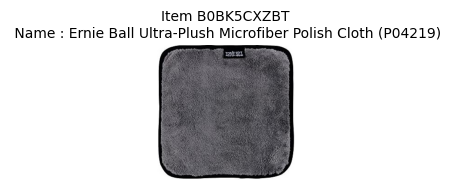

*************** Recommendation number 2 *************** : 
 Product id : B09M7F7LFB, associated weight : 1.981768890891745


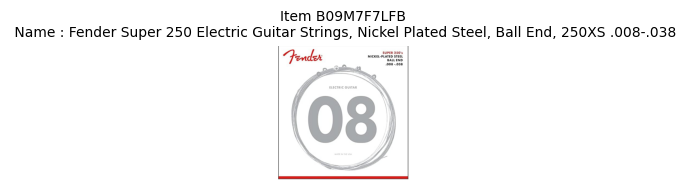

*************** Recommendation number 3 *************** : 
 Product id : B009A5JA98, associated weight : 1.981768890891745


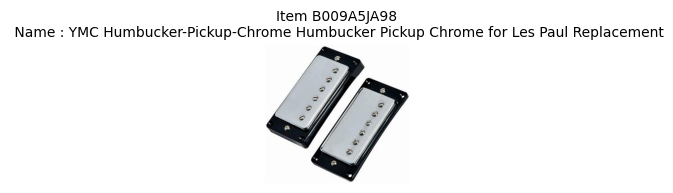

*************** Recommendation number 4 *************** : 
 Product id : B0B2LMZ9RT, associated weight : 1.5136733318311917


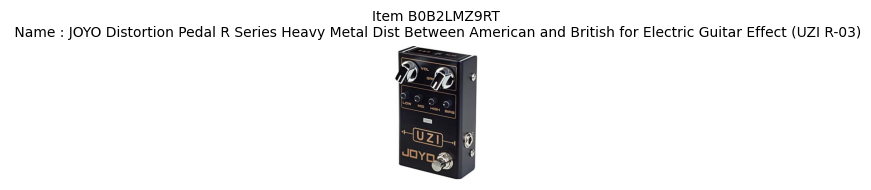

*************** Recommendation number 5 *************** : 
 Product id : B09VBWXMBC, associated weight : 0.5045577772770639


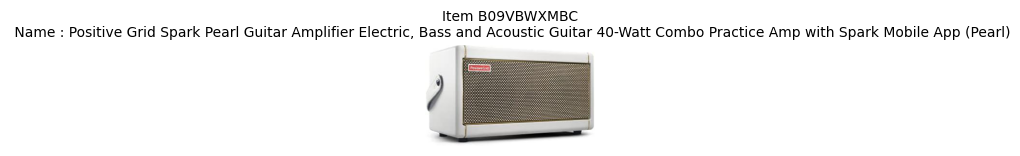

*************** Recommendation number 6 *************** : 
 Product id : B0BSGM6CQ9, associated weight : 0.5045577772770639


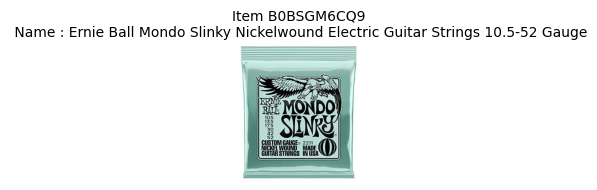

*************** Recommendation number 7 *************** : 
 Product id : B01LQO3GGS, associated weight : 0.49544222272293625


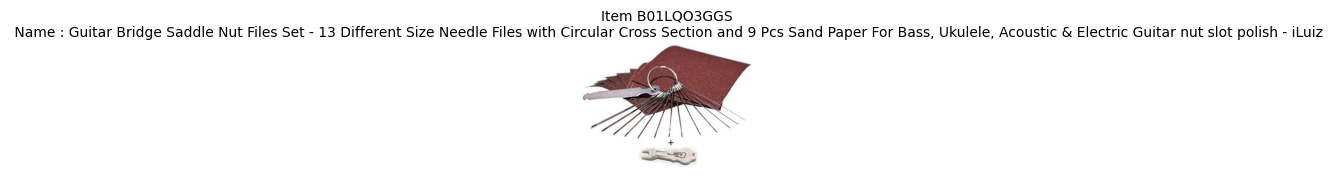

In [26]:
import EDA_functions
i = 1
for index, rows in top_7_recommendation.iterrows(): 
    print (f"*************** Recommendation number {i} *************** : \n Product id : {index}, associated weight : {rows['weighted_averages']}")
    plot_images(index, df_metadata)
    i += 1

#### **Automatique Recommendation** :

#### ( load the python file : recomendations.py for a one shot user recommendation )

The number of unique products is : 1003
The number of unique users is : 5107 

   v v v v v Here is images of the product our user bought in the past :    v v v v v


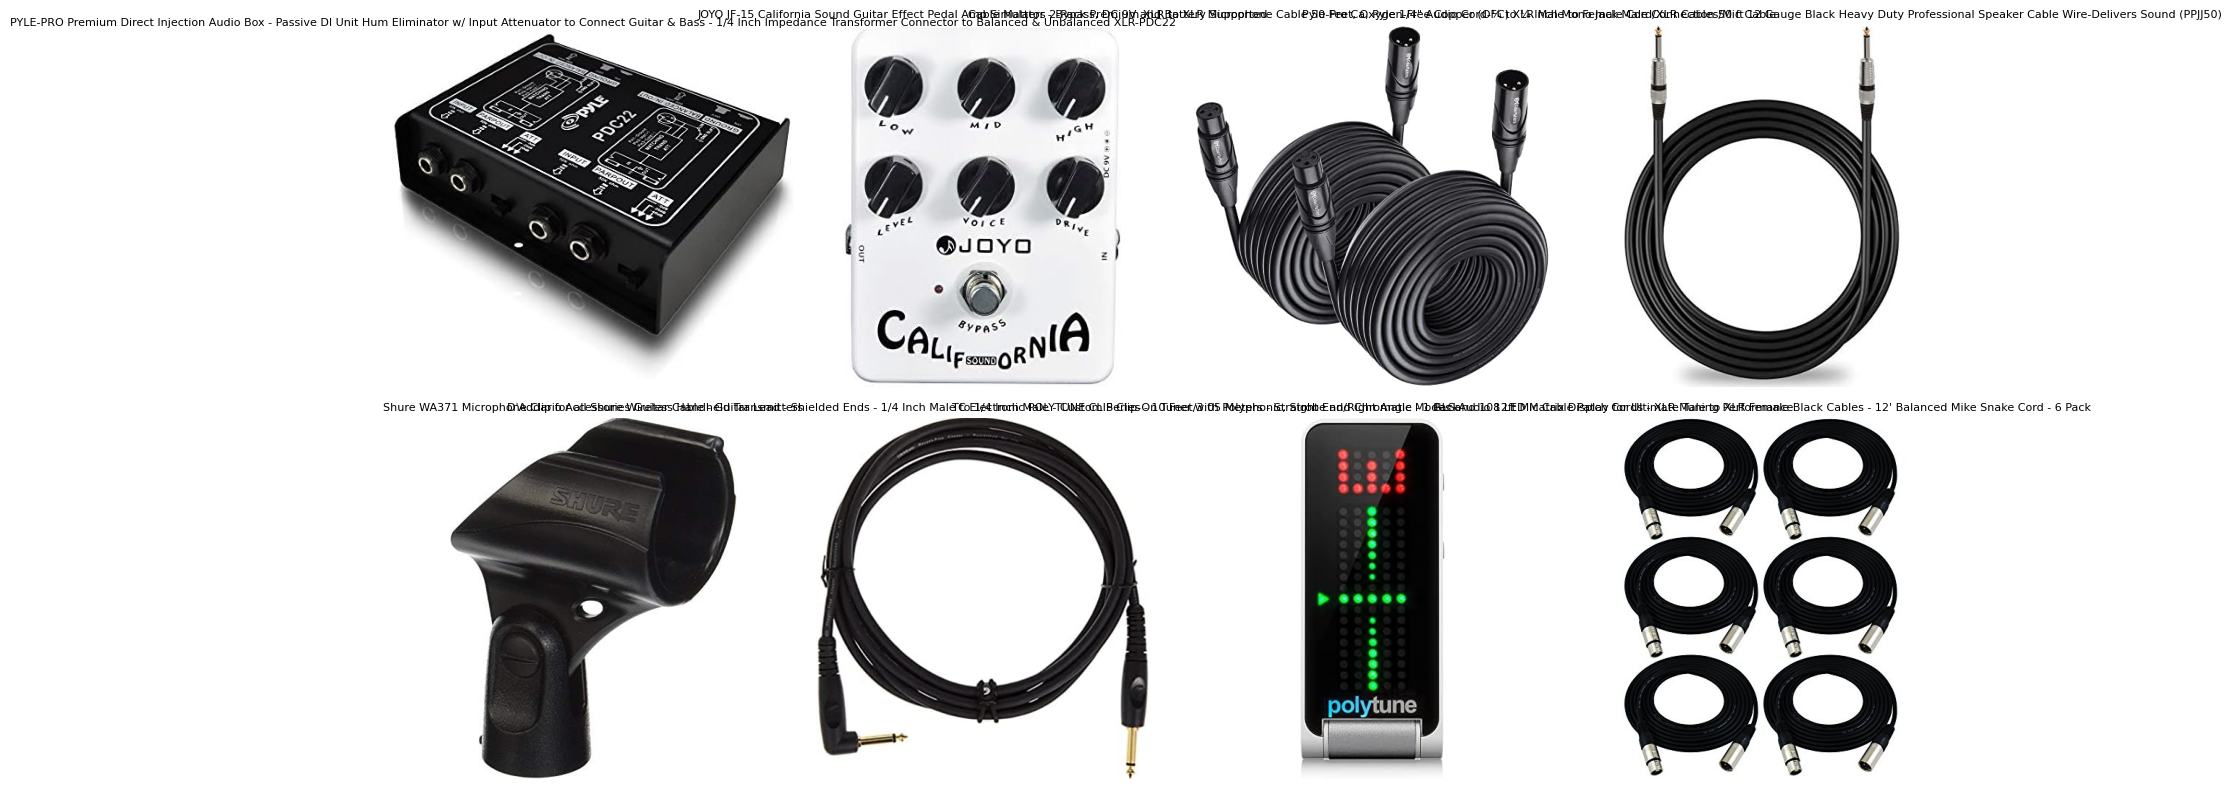

The similar (with similarity bigger than 0.3 of cosine similarity) users to user AHZXMBKQJTVG2J7P7EB5WCYTOLDQ are  : 
User: AHZXMBKQJTVG2J7P7EB5WCYTOLDQ, Similarity: 0.9999999999999999
User: AEPL7HRZFXZPV4HRLAVLIPG6SWMA, Similarity: 0.48791905846982475
User: AH24AXIG2WSMXXKEJWCZOCCBYP4A, Similarity: 0.48578324309888404
User: AEJQKRNJPIVHWSTSY3LBUTISJX2A, Similarity: 0.37371754637596794
User: AHEESJDW67WKM4PH5VA6VLWJWI6Q, Similarity: 0.37371754637596794
User: AGT4CKMXVZIC3HN6VXSIKKYURVSA, Similarity: 0.37371754637596794
User: AG3DT2NJL6FIRTCNKPJPB6FB7YGQ, Similarity: 0.37371754637596794
User: AEFB2SANVBGRV67PYAPK7VWNSFZQ, Similarity: 0.37371754637596794
User: AFJVVDPUVIX2RVK5R3J53FS62IZQ, Similarity: 0.37371754637596794
User: AEXDQ3ET3KGPPTZNC5U72WED6HEA, Similarity: 0.37371754637596794
   v v v v v Here is the products recommended for user  AHZXMBKQJTVG2J7P7EB5WCYTOLDQ :    v v v v v
*************** Recommendation number 1 *************** : 
 Product id : B0007OGTGS, associated weight 

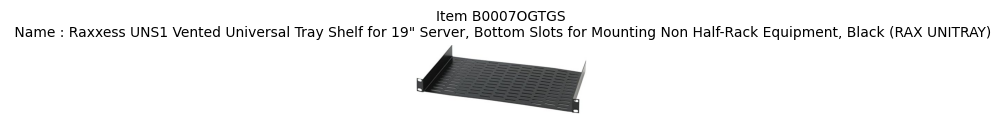

*************** Recommendation number 2 *************** : 
 Product id : B0B52FBC66, associated weight : 0.6766301402205931


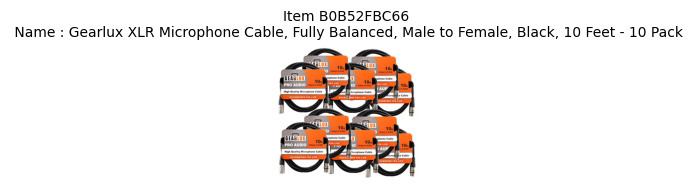

*************** Recommendation number 3 *************** : 
 Product id : B0027V760M, associated weight : 0.6766301402205931


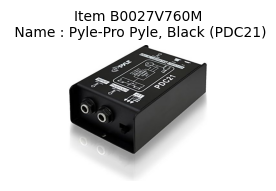

*************** Recommendation number 4 *************** : 
 Product id : B097Q9W8MW, associated weight : 0.5436840329735873


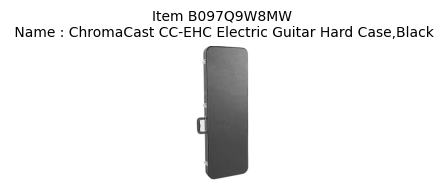

*************** Recommendation number 5 *************** : 
 Product id : B000V1K7FG, associated weight : 0.5436840329735873


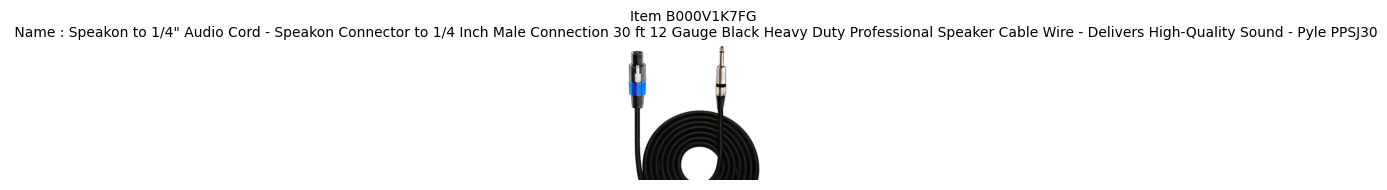

*************** Recommendation number 6 *************** : 
 Product id : B089QY6YYQ, associated weight : 0.5205378312232032


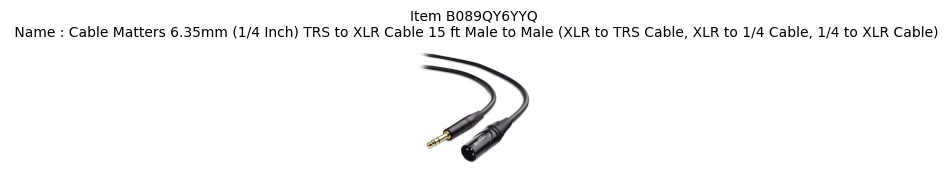

*************** Recommendation number 7 *************** : 
 Product id : B09Y1QWK5W, associated weight : 0.41643026497856256


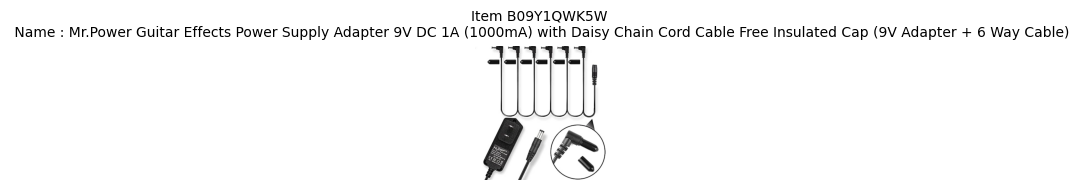

,weighted_averages
id,
B0007OGTGS,0.679605
B0B52FBC66,0.676630
B0027V760M,0.676630
B097Q9W8MW,0.543684
B000V1K7FG,0.543684
B089QY6YYQ,0.520538
B09Y1QWK5W,0.416430


In [27]:
import recommendations

recommendations.Csimilarity_user_recommendation(df_recommendation, "AHZXMBKQJTVG2J7P7EB5WCYTOLDQ", df_metadata)
# Attention certains users n'ont pas de similaires au dessus de 0.3 : "AHZQPH7HHSWLUIQFWEQ54NNKKN6A"
# ok : AG622C3E6PARXNYNYPZ6OWJZ4SHQ

Note: As it is doing in the paper : **Empirical Analysis of Predictive Algorithms for Collaborative Filtering by John S. Breese David Heckerman Carl Kadie**
We deal with the multiples grades by doing the mean of the grading by users, It a kind of Memory based algorithm. Maybe a user bought a product in the past and his opinion changed.
$$
\bar{v}_i = \frac{1}{|I_i|} \sum_{j \in I_i} v_{i,j}
$$

$$were \quad v_{i,j} \quad are \quad the \quad gradings \quad that \quad the \quad user \quad i \quad has \quad done \quad before.
$$

## **End of Introduction**
### Next part : SVD ...